# Research Through Conversation

The idea is to obtain links to web pages based on questions and answers by a AI agents.
There should be also a reflect step which plies over returned results and returns only those relevant to the answer of the expert agent.

In [20]:
from typing import List
from typing_extensions import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field

import asyncio
from aiohttp import ClientSession, ClientError
import operator, os, json, random, re

import instructor
from openai import OpenAI

from IPython.display import Image, Markdown, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.messages.utils import get_buffer_string
from langgraph.constants import Send

from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from ollama import Client, ListResponse

from pprint import pprint

from modules import ConsolidateDocs, ConsolidatedDoc

In [21]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

# fix for async multithreads
import nest_asyncio
nest_asyncio.apply()

In [3]:
client = Client(
      host='ollama',
    )
models: ListResponse = client.list()

json.loads(models.model_dump_json(indent=2))

{'models': [{'model': 'qwen2.5:14b',
   'modified_at': '2025-03-08T13:16:08.873753Z',
   'digest': '7cdf5a0187d5c58cc5d369b255592f7841d1c4696d45a8c8a9489440385b22f6',
   'size': 8988124069,
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2'],
    'parameter_size': '14.8B',
    'quantization_level': 'Q4_K_M'}},
  {'model': 'deepseek-r1:32b',
   'modified_at': '2025-02-03T07:45:31.124246Z',
   'digest': '38056bbcbb2d068501ecb2d5ea9cea9dd4847465f1ab88c4d4a412a9f7792717',
   'size': 19851337640,
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2'],
    'parameter_size': '32.8B',
    'quantization_level': 'Q4_K_M'}},
  {'model': 'qwen2.5-coder:32b',
   'modified_at': '2025-01-26T14:18:39.353482Z',
   'digest': '4bd6cbf2d094264457a17aab6bd6acd1ed7a72fb8f8be3cfb193f63c78dd56df',
   'size': 19851349856,
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'f

In [22]:
# settings

qw = "qwen2.5:14b"
meta = "llama3.1:8b-instruct-fp16"
deepseek = "deepseek-r1:32b"
meta4 = "meta-llama/llama-4-scout-17b-16e-instruct"
meta_sm = "llama3.2:latest"

search_results = 2

tavily_search = TavilySearchResults(max_results=search_results)

## Utils

Some functions that can be reused around the project

In [23]:
# find unique links only

def dedupl(objects: list, prop: str) -> list:

    seen_urls = set()
    unique = []

    for obj in objects:
        obj_prop = getattr(obj, prop)
        if obj_prop not in seen_urls:
            seen_urls.add(obj_prop)
            unique.append(obj)

    return unique

## Initialise Models

Below are the models that we will be using.

- local models
- grok?
- ChatGPT?


In [24]:
def get_llm(model: str, host: str, **kwargs):
    """ Get the llm via LangChain. Depending on the host, it will trigger different LangChain libs to return the llm

    Args:
        model: the model to get. refer to models available by the host
        host: the host / provider of the model. E.g. openAI, ollama, localhost, groq
        kwargs: model settings that we want to pass on: temperature, top_p, max_tokens, etc.

    Returns: 
        the llm created by ChatOllama, ChatOpenAI, ChatGroq, etc
        
    """

    llms = {"openAI": lambda **kwargs: ChatOpenAI(model=model, **kwargs),
            "groq": lambda **kwargs: ChatGroq(model=model, **kwargs)
           }
    llm = llms.get(host, lambda **kwargs: ChatOllama(model=model, base_url=host, **kwargs))(**kwargs)

    return llm

def get_instructed(**kwargs):
    """ Get the llm via instructed to return a list. Depending on the host, it will trigger different LangChain 
    libs to return the llm

    Args:
        model: the model to get. refer to models available by the host
        host: the host / provider of the model. E.g. openAI, ollama, localhost, groq
        kwargs: model settings that we want to pass on: temperature, top_p, max_tokens, etc.

    Returns: 
        the llm created by ChatOllama, ChatOpenAI, ChatGroq, etc
        
    """

    llm = instructor.from_openai(OpenAI(
            base_url="http://ollama:11434/v1",
            api_key="ollama",  # required, but unused
        ),
        mode=instructor.Mode.JSON,
        **kwargs
    )

    return llm
    

## Graph Definitions

Following are the graph definitions

In [25]:
class SearchDoc(BaseModel):
    document_html: str = Field(description="The full HTML of a researched document, returned by the search")
    url: str = Field(description="The url of the document returned by the search")
    summarised: str = Field(description="Summary of the document if above certain length")

class Researcher(MessagesState):
    max_doc_length: int
    max_doc_summary: int
    docs: Annotated[List[SearchDoc], operator.add]
    full_docs: List[ConsolidatedDoc]
    final_report: str
    topic: str
    queries: List[str]
    questions: str
    results: list
    qa_rounds: int
    current_qa_round: int

class ResearcherInput(MessagesState):
    max_doc_length: int
    max_doc_summary: int
    docs: Annotated[List[SearchDoc], operator.add]
    topic: str
    qa_rounds: int

class ResearcherOutput(MessagesState):
    docs: List[SearchDoc]
    topic: str
    final_report: str

class ListOfQueries(BaseModel):
    queries: List[str] = Field(description="List of query strings")

class QualifyingLink(BaseModel):
    url: str = Field(description="Document's URL")
    status: Literal['approve', 'drop'] = Field(description="Wheather URL is approved for further research or dropped out.")
    reason: str = Field(description="Reasoning behind the decision to approve or drop a URL")
    
class WebSearchState(TypedDict):
    topic: str
    queries: List[str]
    questions: str
    qualifying_links: List[QualifyingLink]
    results: Annotated[List[str], operator.add]
    docs: Annotated[List[SearchDoc], operator.add]
    full_docs: List[ConsolidatedDoc]
    max_doc_length: int
    max_doc_summary: int

class WebSearchStateInput(TypedDict):
    questions: HumanMessage
    topic: str
    queries: List[str]
    max_doc_length: int
    max_doc_summary: int

class WebSearchStateOutput(TypedDict):
    results: list
    qualifying_links: List[QualifyingLink]
    docs: List[SearchDoc]


## Nodes

Below are functions that will be used in the graph nodes

In [26]:
def init_researcher(state: Researcher):

    topic = state.get("topic", "")
    messages = state.get("messages", [])

    current_qa_round = 0

    if len(messages) > 0:
        current_qa_round = len([msg for msg in messages if isinstance(msg, AIMessage) and msg.name == "expert"])
    print("QA Round #: ", current_qa_round)
    if topic:
        llm = get_llm(model=qw, host="ollama", temperature=0.1)
        response = llm.invoke([SystemMessage(researcher_system), HumanMessage(researcher_user.format(topic=topic, messages=messages))])

        return {"messages": [HumanMessage(response.content)], 
                "full_docs": [], 
                "results": [],
                "current_qa_round": current_qa_round
               } # reseting the list of docs and results for a new round
    else:
        raise ValueError("Missing topic!")

def get_search_queries(state: Researcher):

    messages = state.get("messages", [])
    
    if messages:
        
        questions = messages[-1].content

        instructed_llm = get_instructed(temperature=0.1)
        print("QUESTIONS:  ", queries_gen_user.format(questions=questions))
        response = instructed_llm.chat.completions.create(
                        model=qw,
                        messages=[{"role": "system", "content": queries_gen_system}, 
                                  {"role": "user", "content": queries_gen_user.format(questions=questions)}],
                        response_model=ListOfQueries
                    )

        print("GENERATED QUERIES: ", response.queries)
        return {"queries": response.queries, "questions": questions}

def expert_answer(state: Researcher):

    docs = state.get("docs", [])
    messages = state.get("messages", [])
    topic = state.get("topic")

    # Create the context string
    context = "\n".join([f"Document {i}: -----------\n\n{doc['summarised'] if doc['summarised'] else doc['document_html']}\n" 
                         for i, doc in enumerate(docs)])
    print("CONTEXT documents length", len(docs))
    print("CONTEXT BODY\n\n", context)
    llm = get_llm(model=qw, host="ollama", temperature=0.2, num_predict=2048, num_ctx=16000)
    response = llm.invoke([SystemMessage(expert_answer_system.format(topic=topic)), 
                           HumanMessage(expert_answer_user.format(messages=messages, context=context))])
    response.name = "expert"
    return {"messages": [response]}


def decider(state: Researcher):

    messages = state.get("messages", [])
    current_qa_round = state.get("current_qa_round", 0)
    if not messages:
        raise ValueError("Messages should not be empty")
        
    qa_rounds = state.get("qa_rounds", 2)
    

    if current_qa_round < qa_rounds - 1:
        return "init_researcher"
    else:
        return "report_writer"

def report_writer(state: Researcher):

    messages = state.get("messages", [])
    topic = state.get("topic", "")

    llm = get_llm(model=meta4, host="groq", temperature=0.3, max_tokens=3092)

    response = llm.invoke([SystemMessage(report_writer_system), HumanMessage(report_writer_user.format(topic=topic, messages=messages))])

    return {"final_report": response.content}
        

In [27]:
def web_search(query: str):
    print('searching for: ', query)
    # Search
    search_docs = tavily_search.invoke(query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"results": [formatted_search_docs]} 

def init_searches(state: WebSearchState):
    
    queries = state.get("queries", [])
    if queries:
        return [Send("web_search", {"query": query}) for query in queries]
    else:
        raise ValueError("Missing queries")

def appraise_results(state: WebSearchState):

    documents = state.get("results", [])
    topic = state.get("topic", "")
    questions = state.get("questions", "")
    full_docs_list = []
    qualified = []

    for doc in documents:
        full_docs_list.extend(doc.split("\n\n---\n\n"))
        
    print('document read: ', len(full_docs_list))
    
    trimmed = [re.sub(r'\n{3,}', '\n\n', doc) for doc in full_docs_list]

    instructed_llm = get_instructed(temperature=0.05)
    
    for doc in trimmed:
        messages=[{"role": "system", "content": appraise_document_system},
                  {"role": "user", "content": appraise_document_user.format(
                      topic=topic,
                      document=doc,
                      questions=questions)
                  }]
    
        # print('prompt: \n\n', messages)
        r = instructed_llm.chat.completions.create(
                model=qw,
                messages=messages,
                response_model=QualifyingLink
            )
        
        qualified.append(r)

    return {"qualifying_links": qualified}

async def docs_loader(state:WebSearchState):

    qualifying_links = state.get("qualifying_links", [])
    dedupled = dedupl(qualifying_links, 'url') 
    approved = [link.url for link in dedupled if link.status == 'approve']
    print('approved', approved)
    cd = ConsolidateDocs(approved)
    full_docs = await cd.load_docs()

    return {"full_docs": full_docs}

def consolidate_docs(state: WebSearchState):
        
    full_docs = state.get("full_docs", [])
    max_doc_length = state.get("max_doc_length", 1250) # set defaults if not inputed
    max_doc_summary = state.get("max_doc_summary", 1000) # set defaults if not inputed

    if full_docs:
        return [Send("doc_summariser", {"doc": doc, 
                                        "max_doc_length": max_doc_length,
                                        "max_doc_summary": max_doc_summary
                                       }) for doc in full_docs]
    else:
        raise ValueError("Missing documents to summarise.")

def doc_summariser(inp):
    doc = inp["doc"].dict()
    max_doc_length = inp["max_doc_length"]
    max_doc_summary = inp["max_doc_summary"]
    llm = get_llm(model=meta_sm, 
                      host="ollama", 
                      temperature='0.1', 
                      num_predict=2048, num_ctx=5000)
    if len(doc["page_content"].split(" ")) > max_doc_length:
        
        response = llm.invoke([SystemMessage(summariser_system), 
                               HumanMessage(summariser_user.format(words=max_doc_summary, 
                                                                   page_content=doc["page_content"]))])
        return {"docs": [{"document_html": doc["page_content"], "url": doc["url"], "summarised": response.content}]}

    else:

        response = llm.invoke([HumanMessage(remove_preamble.format(body=doc["page_content"]))])
        return {"docs": [{"document_html": response.content, "url": doc["url"], "summarised": None}]}
        

## Build the Graphs

In [28]:
builder_search = StateGraph(WebSearchState, input=WebSearchStateInput, output=WebSearchStateOutput)
builder_search.add_node("web_search", web_search)
builder_search.add_node("appraise_results", appraise_results)
builder_search.add_node("docs_loader", docs_loader)
builder_search.add_node("doc_summariser", doc_summariser)
builder_search.add_conditional_edges(START, init_searches, ["web_search"])
builder_search.add_edge("web_search", "appraise_results")
builder_search.add_edge("appraise_results", "docs_loader")
builder_search.add_conditional_edges("docs_loader", consolidate_docs, ["doc_summariser"])
builder_search.add_edge("doc_summariser", END)

# graph_search = builder_search.compile()
# display(Image(graph_search.get_graph(xray=1).draw_mermaid_png()))

In [29]:
builder = StateGraph(Researcher, input=ResearcherInput, output=ResearcherOutput)

builder.add_node("init_researcher", init_researcher)
builder.add_node("get_search_queries", get_search_queries)
builder.add_node("perform_web_search", builder_search.compile())
builder.add_node("expert_answer", expert_answer)
builder.add_node("report_writer", report_writer)

builder.add_edge(START, "init_researcher")
builder.add_edge("init_researcher", "get_search_queries")
builder.add_edge("get_search_queries", "perform_web_search")
builder.add_edge("perform_web_search", "expert_answer")
builder.add_conditional_edges("expert_answer", decider, ["init_researcher", "report_writer"])
builder.add_edge("report_writer", END)

In [30]:
memory = MemorySaver()

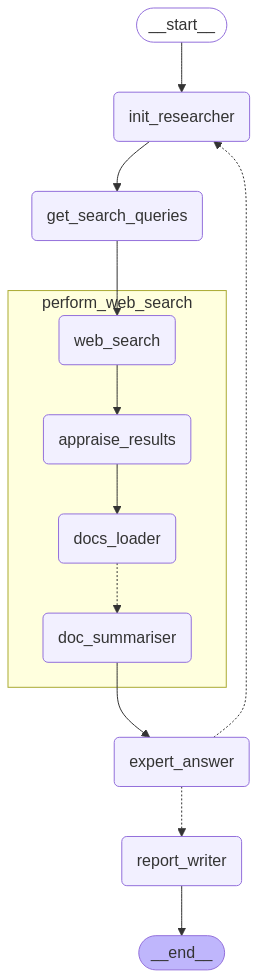

In [31]:
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Prompts

Some prompts that we will use in the graph

In [32]:
## Researcher

researcher_system = """You are a marketing researcher. Your name is Alice and you are very thorough at your job. You will receive a topic of
interest by your manager. You are to involve in conversation with an expert on the topic. Ask series of questions to build insight to the topic."""
researcher_user = """Hi Alice, here is a topic of interest for you to research.
Topic: {topic}

Below you will see the ongoing discussion with the expert:
{messages}

Based on previous conversation what are three questions that you would like to ask our expert in order to gain more knowledge on the topic?
"""

## Query Facilitator --------------------------

queries_gen_system = """You are to facilitate your colleague's research into a topic. Just provide the queries alone
as a list of strings, without any preamble."""
queries_gen_user = """Please see what our researcher is asking below. Can you supply three optimised search queries that I can use 
with google and get some results back to prepare my answer.

Questions:
{questions}
"""

## Results Apraiser --------------------------

appraise_document_system = """Act as a professional researcher. You will receive a document with brief preview returned by 
a search. Your task is to evaluate the document based on its relevance to answering specific questions on a given topic. 
Return a URL for the document with status: 'approve' or 'drop' with 'reason' for your qualification.
Your goal is to streamline the research process by marking 'approve' on relevant documents considered for further reading."""

appraise_document_user = """Below is the document. Your task is to return the Document URL marked 'approve' if it would directly contribute 
to comprehensively answering the posed questions. Mark 'drop' if the Document does not contain useful information towards any of the 
questions.

{document}

Below are the questions I need to answer.

- **Topic:** {topic}
- **Questions:** {questions}

Return your output like this example.

{{
url: Document's url
status: approve | drop
reason: why you think it should be researched further or dropped out
}}
"""

## Summarise Web Search Docs --------------------------

summariser_system = """"You are document summariser. A user would supply you documents to summarise. When summarising, keep factual
data, important events, statistics and other measurable information that will contribute to establish trust in the summarised content."""

summariser_user = """Please summarise the following page content up to {words} words.

content:
{page_content}
"""

expert_answer_system = """You are an expert on the following topic: {topic}. You answer questions by your human friends thoroughly. Visit
each question in detail and provide thoughtful answer. You are to use documents from web search as context so as to provide up to date
replies to the questions.
"""

## Expert Answer Based on Context --------------------------

expert_answer_user = """Here is the context to answer the questions by the researcher. Please stick to the context.

{context}

Below is the current conversation. Please answer each of the researcher questions that havent been answered thoroughly using the 
provided context. Supply detailed answers with as much information as you can extract from the context.

{messages}

"""

## Cleanup Web Result --------------------------

remove_preamble = """Following is text scraped from a web page body tag. Please remove unnecessary preamble and various navigation, 
menus or other irrelevant copy. Return only text that is part of the body copy. Do not edit the body copy itself, just remove information
that appears irrelevant to the main body of the page.

Scraped text follows:
{body}
"""

## Write the Final Report --------------------------

report_writer_system = """You are a professional writer. You will be supplied a topic and discussion between a researcher and expert.
You are to write a 1000 word report on the topic based on the questions and anwsers in the conversation.
"""

report_writer_user = """Following is the conversation between a researcher and an expert. Below is the topic of discussion as well as
the body of messages in the conversation. Use the messages to draft a 1000 word report on the topic so as to serve to the copywriter
for further reasearch and elaboration. Clearly structure your report with intro, main part and summary.

Topic:
{topic}

Conversation text:
{messages}
"""

## Playground

here we can test different functions and settings not to mix them up with the code for the graphs

In [69]:
llm = get_llm(model="gpt-4o-mini-2024-07-18", host="openAI", temperature=0.3)

dict_keys(['temperature'])


In [70]:
llm.invoke("Hi there GPT, how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 15, 'total_tokens': 45, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKrhHV0bIul0WzoiTJji69QJQeGez', 'finish_reason': 'stop', 'logprobs': None}, id='run-bee17a42-dca7-415e-a822-121cf56e57fb-0', usage_metadata={'input_tokens': 15, 'output_tokens': 30, 'total_tokens': 45, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [33]:
cfg = {"configurable": {"thread_id": 102}}

In [36]:
# r = graph.invoke({"topic": "Digital advertising trends for 2025 with highest ROI", "max_doc_length": 1500}, config=cfg)

Questions content="Certainly! Based on the general topic of digital advertising trends for 2025 with the highest ROI, here are three insightful questions I'd like to ask the expert:\n\n1. **Emerging Technologies and Their Impact:**\n   - Can you elaborate on how emerging technologies such as AI-driven personalization, augmented reality (AR), virtual reality (VR), and blockchain will shape digital advertising trends in 2025? How can marketers leverage these technologies to achieve higher ROI?\n\n2. **Shifts in Consumer Behavior:**\n   - Given the rapid changes in consumer behavior due to technological advancements and societal shifts, how do you see this influencing the most effective digital advertising strategies for 2025? What specific tactics should marketers focus on to better connect with their target audience?\n\n3. **Measurement and Analytics:**\n   - With the increasing complexity of digital marketing channels, what new metrics or KPIs will be crucial for measuring ROI in 2025?

In [34]:
async for event in graph.astream({"topic": "What are the top 3 most widely used programming languages in 2025 and what are they used to build?",
                           "max_doc_length": 1000
                          }, 
                          config=cfg, stream_mode="updates", subgraphs=True):
    print(event)

QA Round #:  0
((), {'init_researcher': {'messages': [HumanMessage(content='Certainly! Based on the initial topic, here are three insightful questions I would ask the expert to gather more detailed information:\n\n1. **Trends and Predictions:**\n   - "Based on current trends and technological advancements, which factors do you believe will significantly influence the adoption of programming languages in 2025? How might these factors impact the ranking of the top three languages?"\n\n2. **Use Cases and Applications:**\n   - "Could you elaborate on specific industries or applications where each of the top three programming languages is expected to be most prevalent by 2025? Are there any emerging technologies that will drive their usage in particular sectors?"\n\n3. **Competitive Landscape:**\n   - "How do you see the competitive landscape evolving for these top three languages over the next few years? Are there any new or existing languages that pose a significant threat to their domina

/tmp/ipykernel_173/2891813964.py:86: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  doc = inp["doc"].dict()
/tmp/ipykernel_173/2891813964.py:86: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  doc = inp["doc"].dict()


(('perform_web_search:dd82f91e-9f6a-b352-1858-d6d5a3cab801',), {'doc_summariser': {'docs': [{'document_html': "I'm ready to help. Please go ahead and provide the scraped text from the web page body tag. I'll do my best to remove unnecessary preamble, navigation, menus, and other irrelevant copy, leaving only the relevant body copy.", 'url': 'https://www.simplilearn.com/best-programming-languages-start-learning-today-article', 'summarised': None}]}})
(('perform_web_search:dd82f91e-9f6a-b352-1858-d6d5a3cab801',), {'doc_summariser': {'docs': [{'document_html': "Skip to content\nCourses\nDSA to Development\nGet IBM Certification\nNewly Launched!\nMaster Django Framework\nBecome AWS Certified\nFor Working Professionals\nInterview 101: DSA & System Design\nData Science Training Program\nJAVA Backend Development (Live)\nDevOps Engineering (LIVE)\nData Structures & Algorithms in Python\nFor Students\nPlacement Preparation Course\nData Science (Live)\nData Structure & Algorithm-Self Paced (C++/

/tmp/ipykernel_173/2891813964.py:86: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  doc = inp["doc"].dict()
/tmp/ipykernel_173/2891813964.py:86: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  doc = inp["doc"].dict()
/tmp/ipykernel_173/2891813964.py:86: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  doc = inp["doc"].dict()


(('perform_web_search:c454a159-de98-82d4-542b-c4ed04d78dbf',), {'doc_summariser': {'docs': [{'document_html': 'Developer Ecosystem\n2022\nEnglish\nKey Takeaways\nThe State of\xa0Developer Ecosystem 2022\nThese are the results of the sixth annual survey conducted by JetBrains to capture the landscape of the developer community.\nThis report has been created based on the responses of 29,269 developers from around the world who participated in our study in May–July 2022.\nIt covers a wide range of topics, including programming languages, tools, technologies, demographics, and even fun facts, as well as the lifestyle of developers.\nShare:\nKey Takeaways\n75%\nof the coding community is involved in web development, while 66% involved in backend web development.\nPython\n, the second most popular programming language, has continued to strengthen its position. As a primary language, it outperformed Java and has closed the gap with JavaScript.\nAccording to the community,\nAI/ML\nis the most 

In [35]:
final_state = await graph.aget_state(cfg, subgraphs=True)

In [36]:
print([doc['url'] for doc in final_state.values.get("docs")])

['https://www.geeksforgeeks.org/top-programming-languages-of-the-future-2025/', 'https://www.simplilearn.com/best-programming-languages-start-learning-today-article', 'https://vocal.media/education/the-top-8-new-languages-for-programming-in-2025-48mec0xhy', 'https://www.jetbrains.com/lp/devecosystem-2022/', 'https://mfmfazrin.medium.com/the-state-of-the-developer-ecosystem-2024-a-comprehensive-analysis-6b13ff4cbd04']


In [37]:
print(final_state.values.get("final_report"))

**Report: Top 3 Most Widely Used Programming Languages in 2025 and Their Applications**

**Introduction**

The programming landscape is continuously evolving, influenced by emerging technologies, developer preferences, and industry-specific needs. As we approach 2025, it is essential to identify the top programming languages that are expected to dominate the scene. Based on current trends and expert insights, Python, JavaScript, and Java are predicted to be the top three most widely used programming languages in 2025. This report explores the factors influencing their adoption, specific industries and applications where each language is expected to be most prevalent, and the competitive landscape.

**Main Part**

### Trends and Predictions

Several factors are expected to influence the adoption of programming languages in 2025:

*   **Emerging Technologies**: The rise of artificial intelligence, machine learning, cloud computing, and Internet of Things (IoT) will drive the demand for l

In [36]:
state = graph.get_state(cfg, subgraphs=True)
state.tasks

(PregelTask(id='3bc33035-58e4-5307-3196-45d4a465c316', name='perform_web_search', path=('__pregel_pull', 'perform_web_search'), error='TypeError(\'No synchronous function provided to "docs_loader".\\nEither initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)\')', interrupts=(), state=StateSnapshot(values={'topic': 'How to plan a trip to Crete?', 'queries': ['must visit historical and cultural sites in Crete itinerary', 'lesser known beaches hidden gems Crete travel tips', 'practical tips navigating transportation system Crete language barrier'], 'questions': HumanMessage(content='Certainly! Based on the initial introduction, here are three insightful questions I would ask the expert to gain more detailed information about planning a trip to Crete:\n\n1. **What are some must-visit historical and cultural sites in Crete, and how can visitors best incorporate these into their itinerary?**\n   - This question will help us understand the key attractio

In [81]:
state.values.get("qualifying_links")

In [100]:
test = appraise_results(full_state)

document read:  9


In [23]:
parent_graph_state_before_subgraph = next(
    h for h in graph.get_state_history(cfg) if h.next == ("perform_web_search",)
)

In [24]:
parent_graph_state_before_subgraph.tasks[0].state

{'configurable': {'thread_id': 74,
  'checkpoint_ns': 'perform_web_search:c5d347ca-12b9-ab1e-e983-564fbc9a1dba'}}

In [25]:
subgraph_state_before_model_node = next(h for h in graph.get_state_history(parent_graph_state_before_subgraph.tasks[0].state) 
                                         if h.next == ('docs_loader',))

In [26]:
subgraph_state_before_model_node.config

{'configurable': {'thread_id': 74,
  'checkpoint_ns': 'perform_web_search:c5d347ca-12b9-ab1e-e983-564fbc9a1dba',
  'checkpoint_id': '1f01a0e8-c412-6289-8002-bca428d9bde8',
  'checkpoint_map': {'': '1f01a0e8-40aa-673c-8002-ec0d26d43524',
   'perform_web_search:c5d347ca-12b9-ab1e-e983-564fbc9a1dba': '1f01a0e8-c412-6289-8002-bca428d9bde8'}}}

In [192]:
hist = [h for h in graph.get_state_history(parent_graph_state_before_subgraph.tasks[0].state)]

In [196]:
hist[3].next

('appraise_results',)

In [27]:
# from specific checkpoint
async for event in graph.astream(None, 
                          config=subgraph_state_before_model_node.config, 
                                 stream_mode="updates", 
                                 subgraphs=True):
    print(event)

approved ['https://www.elissos.com/feature-story-on-crete-the-must-visit-landmarks-of-culture/', 'https://www.tripadvisor.com/Attractions-g189413-Activities-c49-t30-Crete.html', 'https://corissia.com/en/crete-destination-museum', 'https://www.magnificentworld.com/things-to-do-in-crete-summer/', 'https://www.getyourguide.com/crete-l404/outdoor-activities-tc1093/', 'https://www.tripadvisor.com/Articles-llhfiSycM8mE-Crete_food.html', 'https://creteinsider.com/what-to-eat-in-crete/', 'https://www.bbcgoodfood.com/travel/europe/top-10-foods-try-crete']
Failed to load https://www.tripadvisor.com/Attractions-g189413-Activities-c49-t30-Crete.html with status code: 403
Failed to load https://www.tripadvisor.com/Articles-llhfiSycM8mE-Crete_food.html with status code: 403
Failed to load https://www.getyourguide.com/crete-l404/outdoor-activities-tc1093/ with status code: 403
Successfully loaded 5 documents.
(('perform_web_search:c5d347ca-12b9-ab1e-e983-564fbc9a1dba',), {'docs_loader': None})
(('per

In [34]:
# resume
async for event in graph.astream(None, 
                          config=cfg, stream_mode="updates", subgraphs=True):
    print(event)

((), {'expert_answer': {'messages': [AIMessage(content="Certainly! Here are detailed answers to your additional questions about visiting Crete with a family:\n\n### 1. Food and Dining Experiences\n\n**Local Restaurants and Tavernas:**\nKissamos is surrounded by beautiful beaches and charming villages, making it an ideal place for dining experiences that showcase authentic Cretan cuisine. Here are some recommendations:\n\n- **Taverna To Kefi (Το Κέφι):** Located in Kissamos, this taverna offers traditional Cretan dishes made with fresh local ingredients. The menu includes grilled meats like lamb and pork, as well as seafood such as octopus and calamari.\n  \n- **Olive Tree Restaurant:** Situated near Falassarna Beach, this restaurant provides a cozy setting for enjoying Cretan specialties. Try their homemade pies (pites) filled with spinach or cheese, along with fresh salads and grilled fish.\n\n**Specific Dishes to Try:**\n- **Sfakianes Pites (Σφακιάνες Πίτες):** These are savory pies 

**Top Digital Media Trends Emerging in 2025: How to Take Advantage of These Trends in Digital Marketing**

**Introduction**

The digital media landscape is rapidly evolving, and 2025 promises to bring about significant changes that will impact digital marketing strategies. Emerging technologies, shifts in consumer behavior, and regulatory changes will play a crucial role in shaping the future of digital media. In this report, we will explore the top digital media trends emerging in 2025 and provide actionable insights on how businesses can take advantage of these trends to drive growth and engagement.

**Main Part**

### Emerging Technologies

By 2025, several emerging technologies will significantly impact digital media trends and offer substantial opportunities for marketers. Key among these include:

*   **AI-Driven Content Creation**: AI is poised to revolutionize the way content is created and personalized. Machine learning algorithms can analyze vast amounts of data to understand

In [66]:
print([link['url'] for link in final_state.values.get("docs")])

TypeError: 'NoneType' object is not iterable

In [149]:
history = [step async for step in graph.aget_state_history(cfg)]

In [150]:
history[1].values

{'messages': [HumanMessage(content='Sure! Based on the initial context, here are three insightful questions I would ask the expert about planning a trip to Crete:\n\n1. **What are some must-visit historical and cultural sites in Crete, and how can visitors best incorporate these into their itinerary?**\n2. **Could you recommend any lesser-known beaches or scenic spots that offer unique experiences for travelers looking to explore beyond the typical tourist areas?**\n3. **What are some practical tips for navigating Crete’s transportation system, especially for those who prefer not to rent a car?**\n\nThese questions aim to provide comprehensive and detailed insights into planning an enriching trip to Crete.', additional_kwargs={}, response_metadata={}, id='28e4140b-96a2-4041-9595-bf403cb127a7')],
 'max_doc_length': 1500,
 'topic': 'How to plan a trip to Crete?',
 'queries': ['must visit historical and cultural sites in Crete itinerary',
  'lesser known beaches scenic spots unique experi

In [144]:
state = await graph.aget_state(history[1].config, subgraphs=True)

In [25]:
d =  await docs_loader(state.tasks[0].state.values)

approved ['https://www.reddit.com/r/crete/comments/16mt1vq/im_staying_for_3_days_in_crete_what_are_absolute/', 'https://rtwin30days.com/crete-greece-5-perfect-days/', 'https://www.facebook.com/groups/greekislandtravel/posts/10162696236575854/', 'https://www.zigzagonearth.com/off-the-beaten-track-crete-unspoilt/', 'https://milimundo.com/my-favourite-off-the-beaten-beaches-of-crete-greece/', 'https://creteinsider.com/communicating-in-crete-greek-words/']
Failed to load https://www.zigzagonearth.com/off-the-beaten-track-crete-unspoilt/ with status code: 403
Successfully loaded 5 documents.


In [106]:
ql = [QualifyingLink(url='https://www.georgioupolihotels.com/cultural-festivals-in-crete-immerse-yourself-in-local-traditions/', 
                     status='approve', 
                     reason='The document provides information about cultural festivals in Crete, which directly relates to the question on must-visit cultural sites and immersing oneself in Cretan culture.'), 
      QualifyingLink(url='https://secrental.com/blog/top-10-festivals-in-crete-must-visit-local-events', 
                     status='approve', 
                     reason='The document provides detailed information about various festivals and cultural events in Crete, which can help travelers plan their trip to immerse themselves in Cretan culture. It directly addresses the question regarding must-visit cultural sites and experiences.'), 
      QualifyingLink(url='https://roadcrete.gr/cultural-festivals-in-crete/', 
                     status='approve', 
                     reason='The document mentions several cultural festivals in Crete, which can contribute to answering the question about must-visit cultural sites and immersing oneself in Cretan culture.'), 
      QualifyingLink(url='https://www.lonelyplanet.com/articles/getting-around-crete', 
                     status='approve', 
                     reason='The document provides detailed information on transportation options in Crete, including buses and ferries, which is directly relevant to the question about efficient ways to get around the island.'), 
      QualifyingLink(url='https://www.quora.com/What-is-the-most-efficient-mode-of-transportation-in-Crete-Are-there-buses-that-cover-the-entire-island-of-Crete', 
                     status='approve', 
                     reason='The document provides information about the bus system in Crete, which is relevant to answering questions related to transportation and logistics for planning a trip.'), 
      QualifyingLink(url='https://travel.usnews.com/Crete_Greece/Getting_Around/', 
                     status='approve', 
                     reason='The document provides information on transportation options in Crete, which is relevant to the question about logistics and transportation.'), 
      QualifyingLink(url='https://www.georgioupolihotels.com/off-the-beaten-path-secret-beaches-and-hidden-villages-in-crete/', 
                     status='approve', 
                     reason='The document discusses hidden treasures in Crete, including secret beaches and charming villages which aligns with the question about lesser-known local spots.'), 
      QualifyingLink(url='https://creteinsider.com/secret-travel-tips-for-crete/', 
                     status='approve', 
                     reason='The document provides valuable insights into lesser-known areas and cultural experiences in Crete, which directly contribute to answering the questions about planning a trip to Crete.'), 
      QualifyingLink(url='https://in.hotels.com/go/greece/places-locals-know-crete', 
                     status='approve', 
                     reason='The document mentions lesser-known places in Crete favored by locals, which can provide valuable insights for travelers looking to experience authentic Cretan culture and avoid tourist crowds. This aligns well with the question about local recommendations.')]

In [103]:
state = await graph.aget_state(cfg, subgraphs=True)

In [104]:
state.values

{'messages': [HumanMessage(content='Sure! Based on the initial context, here are three insightful questions I would ask the expert about planning a trip to Crete:\n\n1. **What are some must-visit historical and cultural sites in Crete, and how can visitors best incorporate these into their itinerary?**\n2. **Could you recommend any lesser-known beaches or scenic spots that offer unique experiences for travelers looking to explore beyond the typical tourist areas?**\n3. **What are some practical tips for navigating Crete’s transportation system, especially for those who prefer not to rent a car?**\n\nThese questions aim to provide comprehensive and detailed insights into planning an enriching trip to Crete.', additional_kwargs={}, response_metadata={}, id='28e4140b-96a2-4041-9595-bf403cb127a7')],
 'max_doc_length': 1500,
 'docs': [{'document_html': "Skip to main content\nWe value your privacy\nReddit and its partners use cookies and similar technologies to provide you with a better expe

In [323]:
groq_llm = get_llm(model=meta4, host="groq", temperature=0.1, max_tokens=4096)


In [324]:
groq_llm.invoke("Can you write me a 500 word history of development of hiphop")

AIMessage(content='Here is a 500-word history of the development of hip-hop:\n\nHip-hop, one of the most influential and popular music genres of the 20th century, has a rich and fascinating history that spans over four decades. Born in the early 1970s in the Bronx, New York City, hip-hop culture was initially a form of self-expression and social commentary for African American and Latino youth.\n\n**The Early Years (1970s)**\n\nHip-hop\'s origins can be traced back to the block parties of DJ Kool Herc, a Jamaican-American DJ who is often credited with inventing hip-hop music. In 1973, Herc began experimenting with turntables and extending breaks (instrumental sections) to create a continuous flow of music that allowed people to dance longer. This innovation laid the foundation for hip-hop\'s distinctive sound.\n\nAs hip-hop evolved, other pioneers emerged. Afrika Bambaataa, a Bronx-based DJ and MC (rapper), organized the Zulu Nation, a group of DJs, MCs, and breakdancers who shared a p